## COMP9727 - 25T2, z5362555 - Song LIN
### Assignment 1

#### PART 1

Q1. 
(i) The regex applied in tutorial 2 removes [^\w\s], which includes anything that is not _alphanumerical (\w)_ or _whitespace separators (\s)_. For most of the data, this is not a problem. However, some punctuation and brackets appear in the artist name and track names, while one particular datapoint is in Korean, though it does provide the translated lyrics, and thus can be processed as usual. To preserve some of this lost information that could be useful, select punctuations will be preseved.

(ii) The evaluation is based on only one training-test split rather than cross validation. The solution to this is to use cross validation.

In [101]:
# All imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import recall_score, classification_report
from sklearn.linear_model import LogisticRegression

In [16]:
# Importing and visualising the dataset
filepath = 'dataset.tsv'
df = pd.read_csv(filepath, sep='\t')
print(df.head())
print(df.info())

# Within this small snippet, not a single symbol/punctuation is seen. 
# Much the dataset is similar, thus we do not apply regex and use any rare occurance of them as information for our model.

                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre                                             lyrics      topic  
0   rock  awake know go see time clear world mirror worl...       dark  
1   rock  shouldn summer pretty build spill ready overfl...  lifestyle  
2  blues  lose deep catch breath think say try break wal...    sadness  
3  blues  run bitter taste take rest feel anchor soul pl...    sadness  
4  blues  think think different set apart sober mind sym...       dark  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):

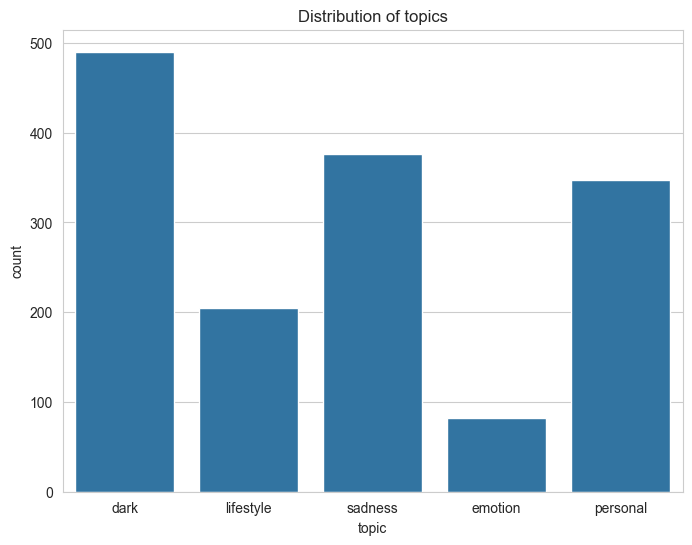

In [17]:
# Graph visualisation of the dataset - modified from tutorial 3
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.countplot(x='topic', data=df)
plt.title('Distribution of topics')
plt.show()

We can clearly see that we have an imbalanced dataset

#### Pre-processing

For this step, we figure out exactly which processing steps produce the best results. This will include the following steps:

1. **Lowercase** - While the dataset looks to be in lowercase already, it doesn't hurt to ensure so.

2. **Regex Leniency** - Regular expression will be expanded to include .() as punctuation. The reason for choosing these is their frequency in roughly three significant figures, while the other punctuations are so infrequent they can be omitted. And while there are datapoints with special unicode characters within the dataset, these are so far and few that it would be more appropriate to treat them as outliers.

3. **Tokenisation** - Turning the string into tokens is needed for NLP to begin with.

4. **Stopword Removal** - For lyrics specifically, removing stopwords may delete too much unique information that could prove useful, specifically in discerning the 'personal' topic, where frequency of pronoun-based stopwords may be useful.

5. **Lemmatisation** - In comparison to stemming, lemmatising uses more computation in order to preserve more contexual information in the results.

Experimentally, the dataset will be copied and applied with different combinations of pre-processing to see exactly which option performs better, in which that particular set will be the prime choice afterwards.

In [ ]:
#####################
# Q2. Preprocessing #
#####################

# nltk packages and lemmatiser
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Concatenating the first five fields into one for training
df['release_date_strings'] = df['release_date'].astype(str)
df['concat'] = (df['artist_name'] + ' ' +
                df['track_name'] + ' ' +
                df['release_date_strings'] + ' ' +
                df['genre'] + ' ' +
                df['lyrics'])

# Tutorial preprocessing steps with our modifications in place, including
# the modified regex and lemmatisation rather than stemming
def preprocess_text(text, stopword, full_regex):
    text = text.lower()
    if full_regex:
        text = re.sub(r'[^\w\s]', '', text)
    else:
        text = re.sub(r'[^\w\s.()]', '', text)
    tokens = word_tokenize(text)
    if stopword:
        tokens = [word for word in tokens if word not in stop_words]
    tokens = [wnl.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# The processed data, along with two more sets to test if our preprocessing
# is truly better.
df['default'] = df['concat'].apply(preprocess_text, args=(False, False))
df['stopword'] = df['concat'].apply(preprocess_text, args=(True, False))
df['fullregex'] = df['concat'].apply(preprocess_text, args=(False, True))

[nltk_data] Downloading package wordnet to C:\Users\Han
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Han
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Han
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [19]:
# Visualisation
print(df['concat'].head())

0    loving the not real lake 2016 rock awake know ...
1    incubus into the summer 2019 rock shouldn summ...
2    reignwolf hardcore 2016 blues lose deep catch ...
3    tedeschi trucks band anyhow 2016 blues run bit...
4    lukas nelson and promise of the real if i star...
Name: concat, dtype: object


In [ ]:
########################
# Q3. Model Comparison #
########################

# Vectorising
vectoriser = CountVectorizer()
X = vectoriser.fit_transform(df['default'])
X_STOPWORD = vectoriser.fit_transform(df['stopword'])
X_FULLREGEX = vectoriser.fit_transform(df['fullregex'])

# Defining the models
bnb = BernoulliNB()
mnb = MultinomialNB()

# Cross validation - using multi-class precision recall
scoring = ['precision_macro', 'recall_macro']
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 727)

# Results
bnb_result = cross_validate(bnb, X, df['topic'], cv = cv, scoring = scoring)
mnb_result = cross_validate(mnb, X, df['topic'], cv = cv, scoring = scoring)
bnb_stopword = cross_validate(bnb, X_STOPWORD, df['topic'], cv = cv, scoring = scoring)
mnb_stopword = cross_validate(mnb, X_STOPWORD, df['topic'], cv = cv, scoring = scoring)
bnb_fullregex = cross_validate(bnb, X_FULLREGEX, df['topic'], cv = cv, scoring = scoring)
mnb_fullregex = cross_validate(mnb, X_FULLREGEX, df['topic'], cv = cv, scoring = scoring)

# Printing the raw data
print(bnb_result)
print(mnb_result)
print(bnb_stopword)
print(mnb_stopword)
print(bnb_fullregex)
print(mnb_fullregex)


c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

{'fit_time': array([0.00399995, 0.00400114, 0.00399947, 0.00400066, 0.00400209]), 'score_time': array([0.00399828, 0.00500011, 0.00399995, 0.00399899, 0.0039978 ]), 'test_precision_macro': array([0.32944015, 0.43133602, 0.52332396, 0.39542569, 0.42343422]), 'test_recall_macro': array([0.38267563, 0.41071656, 0.38701155, 0.3875175 , 0.40937515])}
{'fit_time': array([0.00400043, 0.00400257, 0.00300503, 0.00299931, 0.00300002]), 'score_time': array([0.00300002, 0.00299716, 0.00399637, 0.00399923, 0.00500035]), 'test_precision_macro': array([0.80343909, 0.76300828, 0.74928122, 0.73568461, 0.7337738 ]), 'test_recall_macro': array([0.73973552, 0.72755483, 0.68934218, 0.71393139, 0.71055815])}
{'fit_time': array([0.00400043, 0.00400257, 0.00300312, 0.0030005 , 0.0030005 ]), 'score_time': array([0.00399804, 0.00399995, 0.00499701, 0.00499988, 0.00499892]), 'test_precision_macro': array([0.32720811, 0.45922556, 0.54077068, 0.39860272, 0.42590685]), 'test_recall_macro': array([0.38063482, 0.4066

In [24]:
# Averaged between K-folds
print('MultinomialNB with lenient regex')
print(np.mean(mnb_result['test_precision_macro']))
print(np.mean(mnb_result['test_recall_macro']))
print('MultinomialNB with lenient regex and stopword removal')
print(np.mean(mnb_stopword['test_precision_macro']))
print(np.mean(mnb_stopword['test_recall_macro']))
print('MultinomialNB with full regex')
print(np.mean(mnb_fullregex['test_precision_macro']))
print(np.mean(mnb_fullregex['test_recall_macro']))

MultinomialNB with lenient regex
0.7570373988894594
0.7162244143513296
MultinomialNB with lenient regex and stopword removal
0.7573138600848851
0.719566424428788
MultinomialNB with full regex
0.7565349961318938
0.7156910810179963


#### Results
Overall, BernoulliNB is meant to be more of a binary classifier, it significantly underperforms compared to MultinomialNB with good reason. Thanks to the different preprocessing steps, we can be fairly confident that this difference is likely not to do with a certain preprocess step.

In this setting for rng and 5-fold cross validation, stopword removal and lenient regex are better by a miniscule amount, while full regex without stopword removal performed the worst.

Furthermore, the lenient version of regex did help the model to perform slightly better or equal to full regex. The stopword set, contrary to earlier hypothesis, seemed to slightly improve performance on average. Thus, going forwards, that will be the prime choice, being a combination of modified regex and stopword removal. That being said, the difference is miniscule and inconsistent, which means different distributions of K-fold may make one setting better than the other.

#### Metric
From the lectures, the one introduced as prime choice for an inbalanced multi-class dataset was **precision recall on the macro setting**. Given previous visualisations of the data, we know that it is heavily imbalanced and given to be multiclass, hence, it was chosen as the metric. 

In [ ]:
########################
# Q4. Top N comparison #
########################

# For top N, we will test a variety of data points of N to find the best.
bnb_precision = []
bnb_recall = []
mnb_precision = []
mnb_recall = []

for n in range(1, 500):
    vectoriser = CountVectorizer(max_features = n)
    x = vectoriser.fit_transform(df['stopword'])
    bnb_stopword = cross_validate(bnb, x, df['topic'], cv = cv, scoring = scoring)
    mnb_stopword = cross_validate(mnb, x, df['topic'], cv = cv, scoring = scoring)
    bnb_precision.append(np.average(bnb_stopword['test_precision_macro']))
    bnb_recall.append(np.average(bnb_stopword['test_recall_macro']))
    mnb_precision.append(np.average(mnb_stopword['test_precision_macro']))
    mnb_recall.append(np.average(mnb_stopword['test_recall_macro']))
    


c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

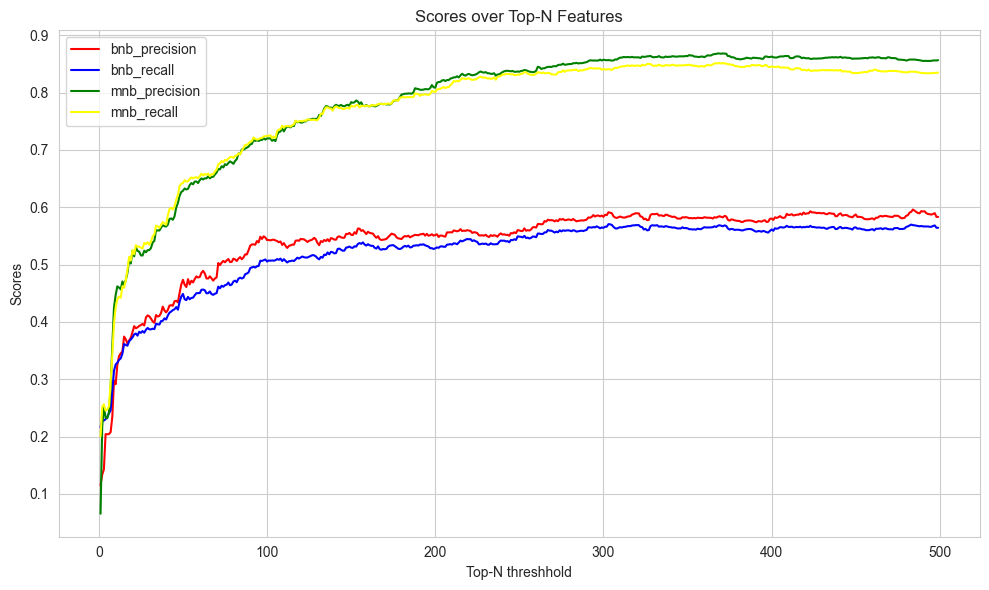

In [ ]:
# Plotting the results
plt.figure(figsize = (10, 6))

x_axis = np.arange(1, 500)

plt.plot(x_axis, bnb_precision, label = 'bnb_precision', color = 'red')
plt.plot(x_axis, bnb_recall, label = 'bnb_recall', color = 'blue')
plt.plot(x_axis, mnb_precision, label = 'mnb_precision', color = 'green')
plt.plot(x_axis, mnb_recall, label = 'mnb_recall', color = 'yellow')

plt.xlabel('Top-N threshhold')
plt.ylabel('Scores')
plt.title('Scores over Top-N Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Top N
Past the top 300 words, neither model shows further signs of significant improvement. That is to say, there is little point to include more than the top three hundred most relevant words with our current setting. The rest of the smaller peaks past that point may be the result of rng or noise, the difference of which is negligible.

#### Logistic Regression
For the third model of comparison, the choice made is logistic regression using the sklearn implementation. From the documentation, while in its base form is designed for binary classification, also possess solvers for use in multi-class. Furthermore, the model comes with an in-built weight adjuster for inbalanced datasets, making it a good choice for this task.

Context wise, this model is a standard baseline for many NLP classification comparisons to begin with, and thus testing it against the two naive-bayes is most appropriate.

All parameters will be set to default except when needing to specify to our problem. The hypothesis is that this model. Logistic Regression is expected to perform better than both types of naive bayes, as it is less efficient for more adaptability in general.

In [ ]:
#####################
# Q5. A third model #
#####################
lrmodel = LogisticRegression(class_weight = 'balanced', # the in-built balancer
                             solver = 'saga', # the best solver that does multiclass, 
                             max_iter = 1000, # 1000 and above recommended for text
                             multi_class = 'multinomial' # self explanatory
                             )
vectoriser = CountVectorizer(max_features = 300)
x = vectoriser.fit_transform(df['stopword'])
lr_stopword = cross_validate(lrmodel, x, df['topic'], cv = cv, scoring = scoring)
print(lr_stopword)

c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reac

{'fit_time': array([0.69900036, 0.70725012, 0.69699717, 0.7120018 , 0.69992232]), 'score_time': array([0.00399876, 0.00500274, 0.00399995, 0.00499845, 0.00399995]), 'test_precision_macro': array([0.77967158, 0.82536939, 0.81052394, 0.92086763, 0.88038179]), 'test_recall_macro': array([0.78876979, 0.84560814, 0.83279989, 0.92267438, 0.89998291])}


c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [39]:
lrmodel = LogisticRegression(class_weight = 'balanced', # the in-built balancer
                             solver = 'saga', # the best solver that does multiclass, 
                             max_iter = 2000, # 1000 and above recommended for text
                             multi_class = 'multinomial' # self explanatory
                             )
lr_stopword = cross_validate(lrmodel, x, df['topic'], cv = cv, scoring = scoring)
print(lr_stopword)

c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was de

{'fit_time': array([1.40323186, 1.05694699, 1.48242736, 1.3610189 , 1.4070003 ]), 'score_time': array([0.00400138, 0.0042088 , 0.00399876, 0.00500083, 0.00399852]), 'test_precision_macro': array([0.76694913, 0.82706194, 0.81794169, 0.91346449, 0.872971  ]), 'test_recall_macro': array([0.77380735, 0.84277091, 0.83688153, 0.89786486, 0.88260486])}


In [41]:
lrmodel = LogisticRegression(class_weight = 'balanced', # the in-built balancer
                             solver = 'saga', # the best solver that does multiclass, 
                             max_iter = 3000, # 1000 and above recommended for text
                             multi_class = 'multinomial' # self explanatory
                             )
lr_stopword = cross_validate(lrmodel, x, df['topic'], cv = cv, scoring = scoring)
print(lr_stopword)
print(np.mean(lr_stopword['test_precision_macro']))
print(np.mean(lr_stopword['test_recall_macro']))

c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Han Lin\AppData\Local\Programs\

{'fit_time': array([1.45778394, 1.04900122, 1.58562326, 1.37760973, 1.39314103]), 'score_time': array([0.00399899, 0.00499916, 0.00399804, 0.00410485, 0.00499868]), 'test_precision_macro': array([0.75903901, 0.82706194, 0.81299219, 0.91346449, 0.872971  ]), 'test_recall_macro': array([0.77117578, 0.84277091, 0.83688153, 0.89786486, 0.88260486])}
0.8371057284673812
0.8462595861696801


Warnings for the maximum iteration being reached continuously occurred until it was written up to 3000. Our hypothesis was on point that it outperformed both of the naive-bayes algorithms by a significant margin. Furthermore, the longer runtime for a single iteration through the dataset is demonstrative of its tradeoff too - less efficiency for a more complex and precise model. 

## Part 2


In [49]:
#####################
# Q1. Preprocessing #
#####################

# Only the 'stopword' data and 'topics' will be needed
df = df[['stopword', 'topic']]

# Split into testing and training sets per specs
df_training = df.iloc[0:750]
df_testing = df[750:1000]
print(df_training.head(), df_testing.head())

                                            stopword      topic
0  loving real lake 2016 rock awake know go see t...       dark
1  incubus summer 2019 rock summer pretty build s...  lifestyle
2  reignwolf hardcore 2016 blue lose deep catch b...    sadness
3  tedeschi truck band anyhow 2016 blue run bitte...    sadness
4  lukas nelson promise real started 2017 blue th...       dark                                               stopword     topic
750  two door cinema club 2019 rock away sugar danc...   sadness
751  kelsea ballerini legend 2018 country golden ma...  personal
752  soccer mommy dog 2018 rock want drag collar ne...      dark
753  score revolution 2017 rock wolf begin howl tim...      dark
754  lindécis sunrise drive 2016 jazz breath suffoc...      dark


In [51]:
# Splitting training data into five matrices
df_dark = df_training[df_training['topic'] == 'dark']
df_lifestyle = df_training[df_training['topic'] == 'lifestyle']
df_sadness = df_training[df_training['topic'] == 'sadness']
df_emotion = df_training[df_training['topic'] == 'emotion']
df_personal = df_training[df_training['topic'] == 'personal']
print(df_dark.head())
print(df_lifestyle.head())
print(df_sadness.head())
print(df_emotion.head())
print(df_personal.head())


                                            stopword topic
0  loving real lake 2016 rock awake know go see t...  dark
4  lukas nelson promise real started 2017 blue th...  dark
6  rebelution trap door 2018 reggae long long roa...  dark
7  thank scientist amateur arsonist handbook 2016...  dark
8  zayde wølf gladiator 2018 rock start climb fac...  dark
                                             stopword      topic
1   incubus summer 2019 rock summer pretty build s...  lifestyle
16  post malone spoil night ( feat . swae lee ) 20...  lifestyle
43  riley richard l.i.t . 2018 jazz libertin class...  lifestyle
45  jon pardi heartache medication 2019 country di...  lifestyle
47  brett young tonight 2018 country lose eye toni...  lifestyle
                                             stopword    topic
2   reignwolf hardcore 2016 blue lose deep catch b...  sadness
3   tedeschi truck band anyhow 2016 blue run bitte...  sadness
9   eli young band never land 2017 country word ye...  sadness
17  

In [57]:
tfidf = TfidfVectorizer(max_features = 300)
matrix_dark = tfidf.fit_transform(df_dark['stopword'])
matrix_lifestyle = tfidf.fit_transform(df_lifestyle['stopword'])
matrix_sadness = tfidf.fit_transform(df_sadness['stopword'])
matrix_emotion = tfidf.fit_transform(df_emotion['stopword'])
matrix_personal = tfidf.fit_transform(df_personal['stopword'])

In [58]:
# Creating user profiles
filepath = 'user1.tsv'
df_user1 = pd.read_csv(filepath, sep='\t')
filepath = 'user2.tsv'
df_user2 = pd.read_csv(filepath, sep='\t')

In [71]:
# User 1
print(df_user1['keywords'][0])
print(df_dark['stopword'][0])
print(len(df_dark))
print(type(df_dark['stopword'][0]))

fire, enemy, pain, storm, fight
loving real lake 2016 rock awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry weather head angry weather head angry weather head know gentle night mindless fight walk wood
246
<class 'str'>


In [88]:
X = tfidf.fit_transform(df['stopword'])
lrmodel.fit(X, df['topic'])

c:\Users\Han Lin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=3000,
                   multi_class='multinomial', solver='saga')

In [89]:
lrmodel.predict(X)

array(['dark', 'lifestyle', 'sadness', ..., 'dark', 'personal', 'sadness'],
      dtype=object)

In [91]:
df_training['topic_preds'] = ""
X = tfidf.fit_transform(df_training['stopword'])
topic_preds = lrmodel.predict(X)
for i in range(0, 750):
    df_training['topic_preds'][i] = topic_preds[i]

C:\Users\Han Lin\AppData\Local\Temp\ipykernel_8060\2618790607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_training['topic_preds'] = ""
C:\Users\Han Lin\AppData\Local\Temp\ipykernel_8060\2618790607.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer,

In [92]:
df_dark = df_training[df_training['topic_preds'] == 'dark']
df_lifestyle = df_training[df_training['topic_preds'] == 'lifestyle']
df_sadness = df_training[df_training['topic_preds'] == 'sadness']
df_emotion = df_training[df_training['topic_preds'] == 'emotion']
df_personal = df_training[df_training['topic_preds'] == 'personal']
print(df_dark.head())
print(df_lifestyle.head())
print(df_sadness.head())
print(df_emotion.head())
print(df_personal.head())

                                            stopword    topic topic_preds
0  loving real lake 2016 rock awake know go see t...     dark        dark
2  reignwolf hardcore 2016 blue lose deep catch b...  sadness        dark
3  tedeschi truck band anyhow 2016 blue run bitte...  sadness        dark
6  rebelution trap door 2018 reggae long long roa...     dark        dark
8  zayde wølf gladiator 2018 rock start climb fac...     dark        dark
                                             stopword      topic topic_preds
1   incubus summer 2019 rock summer pretty build s...  lifestyle   lifestyle
5   tia ray luck 2018 jazz yeah happen real drink ...    emotion   lifestyle
16  post malone spoil night ( feat . swae lee ) 20...  lifestyle   lifestyle
32  mumford son wild 2018 rock burn death make kin...       dark   lifestyle
44  los cafres revolution 2019 reggae know mean re...   personal   lifestyle
                                             stopword    topic topic_preds
7   thank scientist

In [99]:
df_array = [df_dark, df_sadness, df_personal, df_lifestyle, df_emotion]
df_user1['concat'] = ""
for i in range(0, 5):
    for y in range(0, len(df_array[i])):
        current_keywords = set(df_user1.loc[i]['keywords'].split(','))
        current_song = set(df_array[i].iloc[y]['stopword'].split())
        if current_keywords & current_song:
            df_user1['concat'][i] = df_user1['concat'][i] + ' ' + df_array[i].iloc[y]['stopword']

C:\Users\Han Lin\AppData\Local\Temp\ipykernel_8060\3449819292.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_user1['concat'][i] = df_user1['concat'][i] + ' ' + df_array[i].iloc[y]['stopword']
C:\Users\Han Lin\AppData\Local\Temp\ipyke

In [100]:
df_array = [df_sadness, df_emotion]
df_user2['concat'] = ""
for i in range(0, 2):
    for y in range(0, len(df_array[i])):
        current_keywords = set(df_user2.iloc[i]['keywords'].split(','))
        current_song = set(df_array[i].iloc[y]['stopword'].split())
        if current_keywords & current_song:
            df_user2['concat'][i] = df_user2['concat'][i] + ' ' + df_array[i].iloc[y]['stopword']

C:\Users\Han Lin\AppData\Local\Temp\ipykernel_8060\418035189.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_user2['concat'][i] = df_user2['concat'][i] + ' ' + df_array[i].iloc[y]['stopword']


In [98]:
# Vectorising
user1_vec = tfidf.fit_transform(df_user1['concat'])
user2_vec = tfidf.fit_transform(df_user2['concat'])

In [104]:
# Printing the top 20 words
for i in range(0, 5):
    concat = df_user1['concat'][i]
    concat = concat.split()
    counts = Counter(concat)
    print(counts.most_common(20))
    

[('like', 36), ('cry', 25), ('know', 20), ('club', 20), ('day', 20), ('heart', 18), ('start', 18), ('tell', 17), ('fire', 17), ('sing', 16), ('live', 16), ('break', 15), ('hand', 14), ('tear', 14), ('leave', 12), ('riot', 10), ('say', 10), ('baby', 9), ('fall', 9), ('little', 9)]
[('thing', 12), ('drink', 11), ('yeah', 6), ('gon', 3), ('na', 3), ('raise', 3), ('tall', 3), ('glass', 3), ('tonight', 3), ('look', 3), ('life', 3), ('live', 3), ('miss', 3), ('one', 2), ('dream', 2), ('star', 2), ('little', 2), ('tryna', 2), ('morgan', 1), ('evans', 1)]
[('change', 45), ('yeah', 40), ('na', 36), ('life', 27), ('wan', 27), ('follow', 26), ('light', 22), ('thank', 21), ('know', 20), ('heartbreak', 19), ('tell', 14), ('dream', 14), ('everybody', 14), ('think', 12), ('time', 12), ('year', 12), ('cause', 12), ('try', 11), ('like', 11), ('whoa', 10)]
[('night', 33), ('spoil', 30), ('live', 9), ('forever', 9), ('come', 6), ('know', 5), ('time', 4), ('yeah', 4), ('like', 4), ('life', 4), ('feelin', 

In [106]:
for i in range(0, 2):
    concat = df_user2['concat'][i]
    concat = concat.split()
    counts = Counter(concat)
    print(counts.most_common(20))

[('night', 7), ('lose', 6), ('hold', 4), ('darling', 3), ('tight', 3), ('baby', 3), ('come', 3), ('whisper', 3), ('goodbye', 3), ('right', 2), ('midland', 1), ('lost', 1), ('2019', 1), ('country', 1), ('california', 1), ('sunset', 1), ('walk', 1), ('cigarette', 1), ('remember', 1), ('dance', 1)]
[]


Unfinished :(